<IPython.core.display.Javascript object>


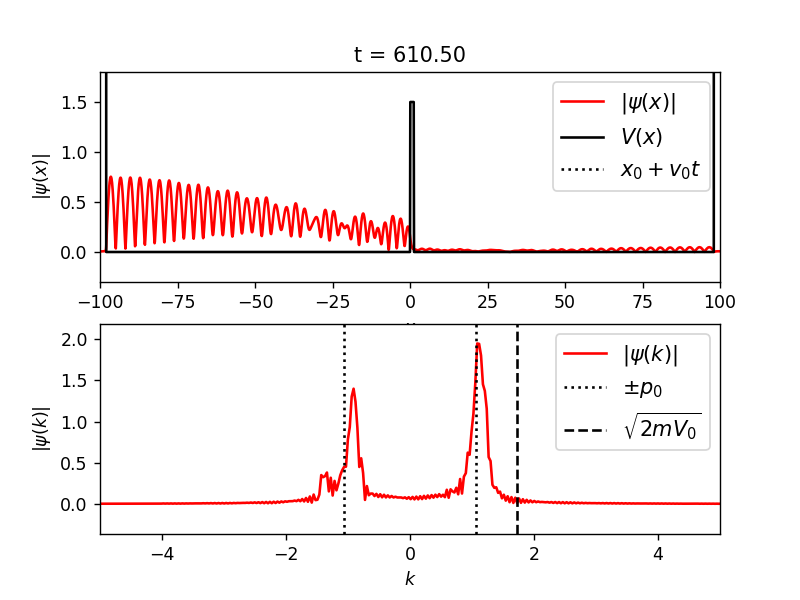

In [3]:
"""
General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

%matplotlib notebook

import numpy as np
from matplotlib import pyplot as pl
from matplotlib import animation
from scipy.fftpack import fft,ifft


class Schrodinger(object):
    """
    Class which implements a numerical solution of the time-dependent
    Schrodinger equation for an arbitrary potential
    """
    def __init__(self, x, psi_x0, V_x,
                 k0 = None, hbar=1, m=1, t0=0.0):
        """
        Parameters
        ----------
        x : array_like, float
            length-N array of evenly spaced spatial coordinates
        psi_x0 : array_like, complex
            length-N array of the initial wave function at time t0
        V_x : array_like, float
             length-N array giving the potential at each x
        k0 : float
            the minimum value of k.  Note that, because of the workings of the
            fast fourier transform, the momentum wave-number will be defined
            in the range
              k0 < k < 2*pi / dx
            where dx = x[1]-x[0].  If you expect nonzero momentum outside this
            range, you must modify the inputs accordingly.  If not specified,
            k0 will be calculated such that the range is [-k0,k0]
        hbar : float
            value of planck's constant (default = 1)
        m : float
            particle mass (default = 1)
        t0 : float
            initial tile (default = 0)
        """
        # Validation of array inputs
        self.x, psi_x0, self.V_x = map(np.asarray, (x, psi_x0, V_x))
        N = self.x.size
        assert self.x.shape == (N,)
        assert psi_x0.shape == (N,)
        assert self.V_x.shape == (N,)

        # Set internal parameters
        self.hbar = hbar
        self.m = m
        self.t = t0
        self.dt_ = None
        self.N = len(x)
        self.dx = self.x[1] - self.x[0]
        self.dk = 2 * np.pi / (self.N * self.dx)

        # set momentum scale
        if k0 == None:
            self.k0 = -0.5 * self.N * self.dk
        else:
            self.k0 = k0
        self.k = self.k0 + self.dk * np.arange(self.N)

        self.psi_x = psi_x0
        self.compute_k_from_x()

        # variables which hold steps in evolution of the
        self.x_evolve_half = None
        self.x_evolve = None
        self.k_evolve = None

        # attributes used for dynamic plotting
        self.psi_x_line = None
        self.psi_k_line = None
        self.V_x_line = None

    def _set_psi_x(self, psi_x):
        self.psi_mod_x = (psi_x * np.exp(-1j * self.k[0] * self.x)
                          * self.dx / np.sqrt(2 * np.pi))

    def _get_psi_x(self):
        return (self.psi_mod_x * np.exp(1j * self.k[0] * self.x)
                * np.sqrt(2 * np.pi) / self.dx)

    def _set_psi_k(self, psi_k):
        self.psi_mod_k = psi_k * np.exp(1j * self.x[0]
                                        * self.dk * np.arange(self.N))

    def _get_psi_k(self):
        return self.psi_mod_k * np.exp(-1j * self.x[0] * 
                                        self.dk * np.arange(self.N))
    
    def _get_dt(self):
        return self.dt_

    def _set_dt(self, dt):
        if dt != self.dt_:
            self.dt_ = dt
            self.x_evolve_half = np.exp(-0.5 * 1j * self.V_x
                                         / self.hbar * dt )
            self.x_evolve = self.x_evolve_half * self.x_evolve_half
            self.k_evolve = np.exp(-0.5 * 1j * self.hbar /
                                    self.m * (self.k * self.k) * dt)
    
    psi_x = property(_get_psi_x, _set_psi_x)
    psi_k = property(_get_psi_k, _set_psi_k)
    dt = property(_get_dt, _set_dt)

    def compute_k_from_x(self):
        self.psi_mod_k = fft(self.psi_mod_x)

    def compute_x_from_k(self):
        self.psi_mod_x = ifft(self.psi_mod_k)

    def time_step(self, dt, Nsteps = 1):
        """
        Perform a series of time-steps via the time-dependent
        Schrodinger Equation.

        Parameters
        ----------
        dt : float
            the small time interval over which to integrate
        Nsteps : float, optional
            the number of intervals to compute.  The total change
            in time at the end of this method will be dt * Nsteps.
            default is N = 1
        """
        self.dt = dt

        if Nsteps > 0:
            self.psi_mod_x *= self.x_evolve_half

        for i in range(Nsteps - 1):
            self.compute_k_from_x()
            self.psi_mod_k *= self.k_evolve
            self.compute_x_from_k()
            self.psi_mod_x *= self.x_evolve

        self.compute_k_from_x()
        self.psi_mod_k *= self.k_evolve

        self.compute_x_from_k()
        self.psi_mod_x *= self.x_evolve_half

        self.compute_k_from_x()

        self.t += dt * Nsteps


######################################################################
# Helper functions for gaussian wave-packets

def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """ 
    return ((a * np.sqrt(np.pi)) ** (-0.5)
            * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))

def gauss_k(k,a,x0,k0):
    """
    analytical fourier transform of gauss_x(x), above
    """
    return ((a / np.sqrt(np.pi))**0.5
            * np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0))


######################################################################
# Utility functions for running the animation

def theta(x):
    """
    theta function :
      returns 0 if x<=0, and 1 if x>0
    """
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y

def square_barrier(x, width, height):
    return height * (theta(x) - theta(x - width))

######################################################################
# Create the animation

# specify time steps and duration
dt = 0.01
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * dt))

# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

# specify range in x coordinate
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

# specify potential
V0 = 1.5
L = hbar / np.sqrt(2 * m * V0)
a = 3 * L
x0 = -60 * L
V_x = square_barrier(x, a, V0)
V_x[x < -98] = 1E6
V_x[x > 98] = 1E6

# specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)

k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,
                psi_x0=psi_x0,
                V_x=V_x,
                hbar=hbar,
                m=m,
                k0=-28)

######################################################################
# Set up plot
fig = pl.figure()

# plotting limits
xlim = (-100, 100)
klim = (-5, 5)

# top axes show the x-space data
ymin = 0
ymax = V0
ax1 = fig.add_subplot(211, xlim=xlim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_x_line, = ax1.plot([], [], c='r', label=r'$|\psi(x)|$')
V_x_line, = ax1.plot([], [], c='k', label=r'$V(x)$')
center_line = ax1.axvline(0, c='k', ls=':',
                          label = r"$x_0 + v_0t$")

title = ax1.set_title("")
ax1.legend(prop=dict(size=12))
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|$')

# bottom axes show the k-space data
ymin = abs(S.psi_k).min()
ymax = abs(S.psi_k).max()
ax2 = fig.add_subplot(212, xlim=klim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_k_line, = ax2.plot([], [], c='r', label=r'$|\psi(k)|$')

p0_line1 = ax2.axvline(-p0 / hbar, c='k', ls=':', label=r'$\pm p_0$')
p0_line2 = ax2.axvline(p0 / hbar, c='k', ls=':')
mV_line = ax2.axvline(np.sqrt(2 * V0) / hbar, c='k', ls='--',
                      label=r'$\sqrt{2mV_0}$')
ax2.legend(prop=dict(size=12))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'$|\psi(k)|$')

V_x_line.set_data(S.x, S.V_x)

######################################################################
# Animate plot
def init():
    psi_x_line.set_data([], [])
    V_x_line.set_data([], [])
    center_line.set_data([], [])

    psi_k_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
    V_x_line.set_data(S.x, S.V_x)
    center_line.set_data(2 * [x0 + S.t * p0 / m], [0, 1])

    psi_k_line.set_data(S.k, abs(S.psi_k))
    title.set_text("t = %.2f" % S.t)
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=30, blit=True)


# uncomment the following line to save the video in mp4 format.  This
# requires either mencoder or ffmpeg to be installed on your system

anim.save('schrodinger_barrier.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

pl.show()